In [1]:
import matplotlib.pyplot as plt  
import pandas as pd
import numpy as np
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

background_pattern =  ['#CCE0CC', '#ADD8E6', '#FFFFCC', '#FFCCCC']

GREY = '#808080' #灰色
DARKGREY ='#333333'

%matplotlib inline

In [2]:
# for Chinese fonts missing error, check this post: https://zhuanlan.zhihu.com/p/566430362


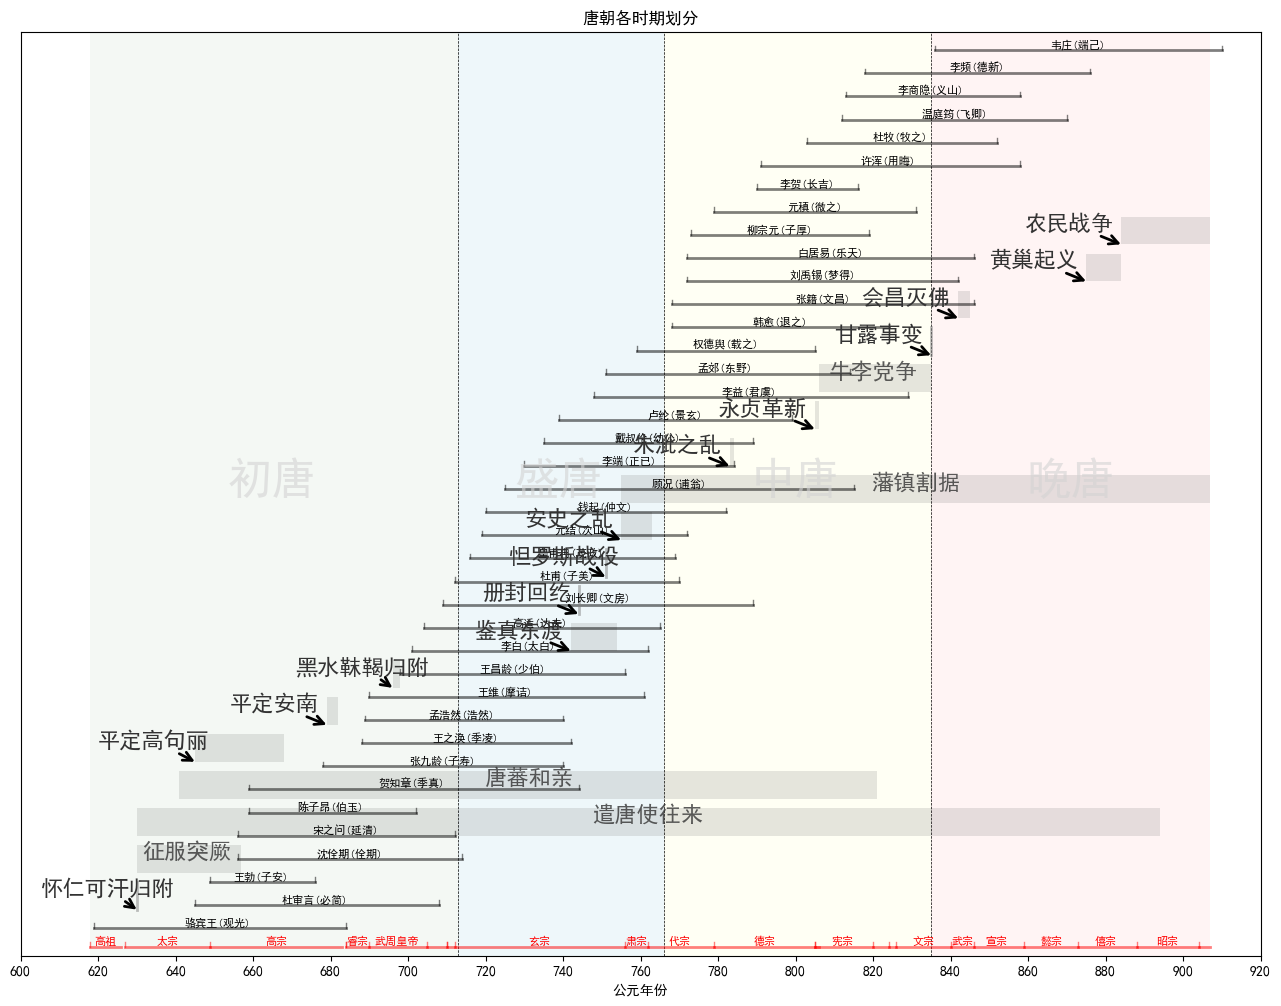

In [6]:
from matplotlib.transforms import Affine2D, offset_copy

class HistoricalPeriodPlotter:
    def __init__(self, fig_size=(16, 12), xlim=(600, 920), ylim=(0,200), grid=20):
        """
        初始化HistoricalPeriodPlotter类，创建一个新的figure和axes对象。

        参数:
        fig_size (tuple[int, int]): 图形的宽度和高度，默认为(16, 8)
        xlim (tuple[int, int]): 横轴的显示范围，默认为(600, 920)
        grid (int): 横轴刻度，默认每隔20年一个刻度
        actual_range (tuple[int, int]): 实际王朝起止年份，用于后续刻度计算
        """
        self.fig, self.ax = plt.subplots(figsize=fig_size)

        xticks=np.arange(xlim[0], xlim[1]+grid, grid)
        # 设置横轴
        self.ax.set_xlim(left=xlim[0], right=xlim[1])
        # self.x0 = actual_range[0]
        # self.x1 = actual_range[1]
        self.x0 = xlim[0]
        self.x1 = xlim[1]       
        self.x_range = self.x1-self.x0
        self.ax.xaxis.set_ticks(xticks)
        self.ax.tick_params(labelbottom=True)
        # print(f"start={self.x0}, end={self.x1}, total {self.x_range}")
        
        # 设置纵轴，不显示纵轴刻度
        self.ax.set_ylim(ylim[0], ylim[1])
        self.ax.yaxis.set_visible(False)
        self.y0 = ylim[0]
        self.y1 = ylim[1]
        self.y_range = self.y1-self.y0

    
    def put_text(self, text='Test', pos = (0.1, 0.1), ha = 'center', va = 'bottom' ):      
        self.ax.text(pos[0], pos[1], text, ha=ha, va=va, transform=self.ax.transAxes)


    def draw_yline(self, x = 635, y = (20,30), color = 'red', lwidth = 2, alpha = 0.5):
        # normalize y
        y0 = (y[0]-self.y0)/self.y_range
        y1 = (y[1]-self.y0)/self.y_range
        
        self.ax.axvline(x=x, ymin=y0, ymax=y1, color=color, linewidth=lwidth, alpha=alpha)
    
    def draw_xline(self, y = 10, x = (635, 660), color = 'red', lwidth = 2, alpha = 0.5):
        # normalize x
        x0 = (x[0]-self.x0)/self.x_range
        x1 = (x[1]-self.x0)/self.x_range

        # 有点怪， y要用整数， x要用小数？
        self.ax.axhline(y=y, xmin=x0, xmax=x1, color=color, linewidth=lwidth, alpha=alpha)  
        # not work
        # self.ax.axhline(y=y, xmin=x[0], xmax=x[1], color=color, linewidth=lwidth)

    def draw_segline_x(self, y:int, x:tuple, draw_y:bool ='both', lwidth=2, color ='black'):
        self.draw_xline(y=y, x=x, lwidth= lwidth, color=color)
        
        if draw_y in ['left','both']: 
            # self.ax.axvline(x0, ymin=y-0.01, ymax=y, color=color, linewidth=lwidth)
            self.draw_yline(x=x[0], y=(y, y+1), color=color, lwidth= lwidth//2)
        if draw_y in ['right','both']:
            # self.ax.axvline(x1, ymin=y-0.01, ymax=y, color=color, linewidth=lwidth)
            self.draw_yline(x=x[1], y=(y, y+1), color=color, lwidth= lwidth//2)
        
    def plot_emperors_from_csv(self, emperor_file_name, y_offset=1, color='red'):
        """
        从指定的CSV文件中读取皇帝在位数据并在第一个坐标轴上方绘制线段及庙号。

        参数:
        emperor_file_name (str): 包含皇帝信息的CSV文件路径
        y_offset (float): 线段相对于原坐标x轴的垂直偏移量，默认为1(x轴向上1个y单位)
        color (str): 线段的颜色，默认为黑色
        """
        emperors_df = pd.read_csv(emperor_file_name)

        for index, row in emperors_df.iterrows():
            name = row['姓名']
            #temple_name = row['庙号']
            temple_name = row['庙号'].replace("唐", "")
            start_year = row['在位开始时间']
            end_year = row['在位结束时间']
            years = row['在位年数']
            remarks = row['备注']
            # print(f"{temple_name}:{start_year}--{end_year}")
            # 绘制线段
            self.draw_segline_x(y=y_offset+1, x=(start_year, end_year), draw_y='left', color = color)
            # 添加庙号和备注文本
            mid_year = (start_year + end_year) // 2
            text_transform = offset_copy(self.ax.transData, fig=self.fig, y=5, units='dots')
            emperor_text = temple_name
            if years > 5: # 只标出在位时间>5年的皇帝
                self.ax.text(mid_year, y_offset, emperor_text,
                             transform=text_transform,
                             ha='center', va='bottom', fontsize=8, color = color)
    
    def plot_poet_from_csv(self, poet_file_name, y_offset=5, color='black'):
        poet_df = pd.read_csv(poet_file_name)
        poet_df.sort_values(by='出生年份', inplace=True) #从小到大排序

        y_offset_step = 5
        this_y_offset = y_offset
        for index, row in poet_df.iterrows():
            name = row['姓名']
            name_word = row['字']
            born_year = row['出生年份']
            end_year = row['去世年份']
            years = row['年龄']
            remarks = row['备注']
            # 绘制线段
            self.draw_segline_x(y=this_y_offset+1, x=(born_year, end_year), draw_y='both', color=color)
            # 添加庙号和备注文本
            mid_year = (born_year + end_year) // 2
            text_transform = offset_copy(self.ax.transData, fig=self.fig, y=5, units='dots')
            emperor_text = name + '(' + name_word + ')'

            self.ax.text(mid_year, this_y_offset, emperor_text,
                         transform=text_transform,
                         ha='center', va='bottom', fontsize=8, color=color)

            this_y_offset += y_offset_step
    
    def plot_periods_from_csv(self, file_name, colors):
        """
        从指定的CSV文件中读取数据并绘制历史时期背景。

        参数:
        file_name (str): CSV文件路径
        colors (list[str]): 颜色列表，用于填充各个时期
        """
        df = pd.read_csv(file_name)
        
        periods = df[['起始年代', '结束年代']].values

        # 在水平轴（X轴）上的一个区间内填充颜色
        for i, (start, end) in enumerate(periods):
            self.ax.axvspan(start, end, facecolor=colors[i], alpha=0.2)

        x_pos = (df['起始年代'] + df['结束年代']) // 2
        y_pos = (self.y0 + self.y1) // 2
        for i, x_pos in enumerate(x_pos):
            period_name = df.iloc[i]['时期']
            self.ax.text(x_pos, y_pos, period_name,
                         ha='center', fontsize=32, color='lightgray', alpha=0.6,
                         rotation=90 if len(period_name) > 4 else 0)

        # 可选：添加竖直虚线作为区分
        for start, end in zip(periods[:-1, 1], periods[1:, 0]):
            self.ax.axvline(x=start, color='black', linewidth=0.5, linestyle='--')


    def plot_events_from_csv(self, file_name, offset=10, rect_height=6, color=GREY, alpha = 0.2):
        """
        从指定的CSV文件中读取数据并绘制历史事件背景。

        参数:
        file_name (str): CSV文件路径
        """
        df = pd.read_csv(file_name)
        df.sort_values(by=['起始年代', '结束年代'], inplace=True) #从小到大排序

        this_offset = offset
        debug = 1
        for index, row in df.iterrows():
            name = row['事件名称']
            type = row['类型']
            start = row['起始年代']
            end = row['结束年代']
            years = row['历时']
            # remarks = row['备注']

            # 在（x0,y0）(x1,y1)的矩形范围内填充
            if end > start:
                self.ax.fill_between(x=[start, end], y1=this_offset, y2=this_offset+rect_height, facecolor=GREY, alpha=alpha)
            elif end == start:
                self.draw_yline(x=start, y=(this_offset, this_offset+rect_height), color=GREY)
                

            txt_y = this_offset + rect_height //2
            txt_x = (start + end) // 2
            
            if (end - start) > 25:
                self.ax.text(txt_x, txt_y, name, ha='center', fontsize= 16, color=DARKGREY, alpha=0.8)
            else:
                arrow_end = (start, this_offset)
                arrow_start = (start-25, txt_y)
                # self.ax.text(txt_x, txt_y, name, ha='center', fontsize= 16, color=DARKGREY, alpha=0.8)
                self.ax.annotate(name, xy=arrow_end, xycoords='data', xytext=arrow_start, 
                                 textcoords='data', arrowprops=dict(arrowstyle="->", linewidth=2, shrinkA=0, shrinkB=0),
                                 fontsize=16, color=DARKGREY)  # 可选地设置字体大小和颜色
            this_offset += (rect_height+2)
    
    def set_title_and_xlabel(self, title='历史时期划分', xlabel='公元年份'):
        """
        设置图形的标题和横轴标签
        """
        self.ax.set_title(title)
        self.ax.set_xlabel(xlabel)

    def show_plot(self):
        """
        显示图形
        """
        plt.show()
        

# 使用示例
plotter = HistoricalPeriodPlotter()
# plotter.put_text()
# plotter.draw_xline()
# plotter.draw_yline()
plotter.plot_periods_from_csv('tang-phase.csv',background_pattern)
plotter.plot_emperors_from_csv('tang-emperor.csv')
plotter.plot_poet_from_csv('tang-poet.csv')
plotter.plot_events_from_csv('tang-events.csv')

plotter.set_title_and_xlabel('唐朝各时期划分')

plotter.show_plot()

